# Dogs vs Cats Competition

In this competition, we'll write an algorithm to classify whether images contain either a dog or a cat.  This is easy for humans, dogs, and cats. Your computer will find it a bit more difficult. Check more info in [Kaggle](https://www.kaggle.com/c/dogs-vs-cats)

## State of the art

In 2013, the literature suggested that machine classifiers can score above 82% accuracy on this task. Source: [Machine Learning Attacks Against the Asirra CAPTCHA](http://xenon.stanford.edu/~pgolle/papers/dogcat.pdf)


Five years later, using transfer learning we can achieve a much better score with little data and in just a few epochs.
Let's find out how!

First, let's **define** some constants for the folders we'll be working with. Different folders for training images and test images. Another folder for temporary files such as the weights of the model or the numpy vectors with the data. Finally, an output folder for the submission's file.

Another important define is the **IMG_SHAPE**. Later, I'll explain why these values.

In [1]:
# defines

DIR_IMG_TRAIN = 'datasets/train/'
DIR_IMG_TEST = 'datasets/test/'
DIR_TMP_DATA = 'tmp'
DIR_OUTPUT = 'output'

IMG_SHAPE = (150,150,3)

Some **imports** we'll need.

In [2]:
# imports

import os
import matplotlib.pyplot as plt
from scipy.ndimage import imread
from scipy.misc import imsave
import numpy as np
import time

%matplotlib inline


## Exploring the data

Now we've imported some libraries that help us figure out the data in the dataset. Let's explore the data for a moment.

First, visualization of a 'cat' example from the train folder using matplotlib and scipy library:

Image have shape: (144, 175, 3)


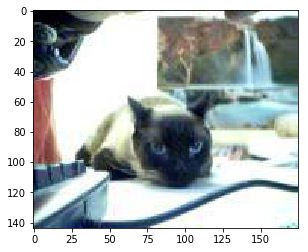

In [3]:
sample_img_path = os.path.join(DIR_IMG_TRAIN,'cat.5.jpg')
sample_img = imread(sample_img_path)
plt.imshow(sample_img)
print ('Image have shape: {}'.format(sample_img.shape))

Now, a dog example:

Image have shape: (375, 499, 3)


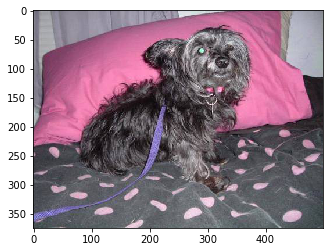

In [4]:
# dog example
sample_img_path = os.path.join(DIR_IMG_TRAIN,'dog.0.jpg')
sample_img = imread(sample_img_path)
plt.imshow(sample_img)
print ('Image have shape: {}'.format(sample_img.shape))

## Useful functions for loading, resizing and normalizing the input images

We want to have a consistent input, so here we have a function that loads and resizes the image. Note the use of **Keras** built-in functions.

Using TensorFlow backend.


Dog #0 as image:


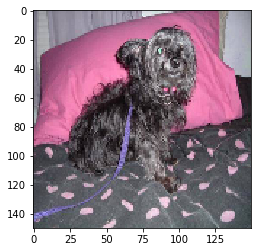

In [5]:
# as long as images have different sizes, let's resize!

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

def loadAndResizeImage (img, w, h):
    '''
    loads the image in 'img' path and returns a PIL image of size (w,h)
    '''
    return image.load_img (img, target_size=(w,h))

# dog example resized
dog_index = 0
sample_img_path = os.path.join(DIR_IMG_TRAIN,'dog.'+str(dog_index)+'.jpg')
sample_img = loadAndResizeImage (sample_img_path, IMG_SHAPE[0], IMG_SHAPE[1])
plt.imshow(sample_img)
print ('Dog #'+str(dog_index)+' as image:')

Some other useful functions to work with the labels and that help loading, resizing and normalizing the data.

_getLabelFromScore_ returns the label for a given score. This is an important decision: 

* 1 -> indicates: 'in the picture there's a dog'
* 0 -> indicates: 'in the picture there's a cat'

So, the threshold will be at 0.5.

In [6]:
from PIL import Image

def getLabel (X):
    """
    Return the label for an element based on the filename: 
        dog -> 1 
        cat -> 0
    """
    if ('dog' in X):
        return 1
    else:
        return 0
    
def getLabels (X):
    """
    Returns an array that contains the label for each X
    """
    return np.array([getLabel(X[i]) for i in range(len(X))])

def getLabelFromScore (score):
    """
    Returns the label based on the probability
    if score >= 0.5, return 'dog'
    else return 'cat'
    """
    if (score >=0.5):
        return 'dog'
    else:
        return 'cat'

def normalizedArrayFromImageInPath (image_path, img_shape):
    """
    returns an the image in 'image' path normalized in an np array
    """
    img = loadAndResizeImage (image_path, img_shape[0], img_shape[1])
    return image.img_to_array(img) / 255.

def loadResizeNormalizeImages (basepath, path_array, img_shape):
    """
    Loads the images from the path 
    and returns them in an array
    """
    images = np.empty ((len(path_array), img_shape[0], img_shape[1], img_shape[2]), dtype=np.float32)
    for i in range (len(path_array)):
        images[i] = normalizedArrayFromImageInPath (os.path.join(basepath,path_array[i]), img_shape)
    return images

## Create training and validation sets

As stated at the beginning of this notebook, we'll be using a fraction of the total available examples. We'll use just 1000 images for training and 100 for validation.

For training we pick the first 1.000 images. For validation, we pick the following 100 images.

Note that in the training folders there are **25.000** images in total.

In [7]:
import os
import numpy as np

train_imgs = os.listdir(DIR_IMG_TRAIN)

train_examples = 1000
train_x = train_imgs[:train_examples]
train_y = getLabels (train_x)

print ("Number of training examples = {}".format(len(train_x)))
print ("Number of training labels = {}".format(len(train_y)))

validation_examples = 100
validation_x = train_imgs[train_examples:train_examples+validation_examples]
validation_y = getLabels (validation_x)

print ("Number of validation examples = {}".format (len(validation_x)))
print ("Number of validation labels = {}".format(len(validation_y)))

Number of training examples = 1000
Number of training labels = 1000
Number of validation examples = 100
Number of validation labels = 100


## Building the numpy arrays containing the data

In order to accelerate the training and validation steps, we can read the images, prepare them and save them in an numpy object on a file.

Because this action can take a long time, we save it in a file. In fact, this is not necessary because we are just using 1.100 images, but it is a good practice. You can come back later and skip the previous step. 

After that, we've reached the first **checkpoint**. 

In [8]:
img_train_x = loadResizeNormalizeImages (DIR_IMG_TRAIN, train_x, IMG_SHAPE)
np.save (os.path.join(DIR_TMP_DATA,'train_x'), img_train_x)
print (img_train_x.shape)
print ('Input X for training saved!')

img_validation_x = loadResizeNormalizeImages (DIR_IMG_TRAIN, validation_x, IMG_SHAPE)
np.save (os.path.join(DIR_TMP_DATA,'validation_x'), img_validation_x)
print (img_validation_x.shape)
print ('Input X for validation saved!')

print ('Checkpoint 1')

(1000, 150, 150, 3)
Input X for training saved!
(100, 150, 150, 3)
Input X for validation saved!
Checkpoint 1


## Dogs vs Cats proportion in the sets

It is very important that the sets we've built are not strongly polarized. That means, the percentage of dogs and cats in the set must be around 50%. To check that, we can use the following function based on the given labels:

In [9]:
def dogsVsCatsProportion (labels):
    cats = 0
    dogs = 0
    for label in labels:
        if (label == 1):
            dogs = dogs + 1
        else:
            cats = cats + 1

    cats_percent = (cats/len(labels))*100.0
    dogs_percent = 100.0 - cats_percent

    return dogs_percent, cats_percent

In [10]:
img_train_x = np.load (os.path.join(DIR_TMP_DATA,'train_x')+'.npy')
img_validation_x = np.load (os.path.join(DIR_TMP_DATA,'validation_x')+'.npy')

print ('Input X train and validation loaded!')

dogs, cats = dogsVsCatsProportion (train_y)
print ("--> Training set: cats represent "+str(cats)+"% of the total")
print ("    Dogs represent "+str(dogs))

dogs, cats = dogsVsCatsProportion (validation_y)
print ("--> Validation set: cats represent "+str(cats)+"% of the total")
print ("    Dogs represent "+str(dogs))

Input X train and validation loaded!
--> Training set: cats represent 49.7% of the total
    Dogs represent 50.3
--> Validation set: cats represent 47.0% of the total
    Dogs represent 53.0


as we can see, the proportion is balanced in the training set. It is not so well balanced in the validation set, but this is not so relevant.

## Building the model

We'll use the [inceptionV3](https://keras.io/applications/#inceptionv3) model. This is one of the best models for image classification. We'll remove the top of the model used for classification of the CIFAR dataset, and we'll plug our little model to classify the output of the inception model between dog and cat. 

Reading the Keras documentation, we find:

_"It should have exactly 3 inputs channels, and width and height should be no smaller than 139. E.g. (150, 150, 3) would be one valid value."_ 

So let's stick to this value. That is where the value for the global constant IMG_SHAPE comes from. 

In our model in top, we'll be using 3 layers with 1024, 256 and 32 units respectively. Between them, we set **dropout** to help the model generalize better. This is specially important in that case because we're using just 1.000 images for training.

It is also very important to _freeze_ the layers of the inception model. We don't want to train the inception model. We just want that the inception model to extract the features of the images from dogs and cats. Later, our model on top will learn how to separate dogs from cats using those features.

In [11]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add dropout
x = Dropout (0.5)(x)
# one fully connected layer more
x = Dense(256, activation='relu')(x)
# add dropout
x = Dropout (0.5)(x)
# one fully connected layer more
x = Dense(32, activation='relu')(x)
# and a logistic layer --
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Training

With the data and the model we've built, we are going to traing the model for only 6 epochs. That means, the model will be trained using the 1.000 images 6 times. At the end of each training, the model will be evaluated against the validation data.

In [12]:
# train the model on the new data for a few epochs
model.fit (x=img_train_x, y=train_y, 
           batch_size=16, epochs=6, 
           validation_data=(img_validation_x, validation_y))

Train on 1000 samples, validate on 100 samples
Epoch 1/6
1000/1000 [==============================] - 75s 75ms/step - loss: 0.8085 - acc: 0.6140 - val_loss: 0.4265 - val_acc: 0.8800
Epoch 2/6
1000/1000 [==============================] - 74s 74ms/step - loss: 0.6192 - acc: 0.6810 - val_loss: 0.2380 - val_acc: 0.8900
Epoch 3/6
1000/1000 [==============================] - 75s 75ms/step - loss: 0.5746 - acc: 0.7050 - val_loss: 0.1899 - val_acc: 0.9300
Epoch 4/6
1000/1000 [==============================] - 79s 79ms/step - loss: 0.4823 - acc: 0.7830 - val_loss: 0.6243 - val_acc: 0.8600
Epoch 5/6
1000/1000 [==============================] - 77s 77ms/step - loss: 0.4746 - acc: 0.7710 - val_loss: 0.1485 - val_acc: 0.9000
Epoch 6/6
1000/1000 [==============================] - 74s 74ms/step - loss: 0.4675 - acc: 0.7910 - val_loss: 0.1838 - val_acc: 0.9200


Thanks to the adam optimizer we can see that the model learns very fast. The first validation accuracy is already 88%.

At the end of this training we can expect an accuracy of around 93% and a log loss of around 0.19.

Let's see how to evaluate this against test data. But before that, we are going to save the model. This is the second checkpoint. If we come back later we can skip most of the steps above and directly load the model from the created file.

## Saving and loading the Keras model

Save and load the Keras model from file.

In [13]:
print ('Saving the model...')
model.save(os.path.join(DIR_TMP_DATA,'model.h5'))
print ('Model saved! Filename: {}'.format (os.path.join(DIR_TMP_DATA,'model.h5')))
print ('Checkpoint 2')

Saving the model...
Model saved! Filename: tmp/model.h5
Checkpoint 2


In [14]:
from keras.models import load_model
model = load_model(os.path.join(DIR_TMP_DATA,'model.h5'))
print ('Model loaded!')

Model loaded!


## Evaluation

It is time to evaluate the training. We are going to use 250 images from the training set that **the model didn't see before.** This is important, because it let us know hoe well our model is generalizing. The chosen images are the last 250 available in the training folder.

As before, we build the numpy array containing the test images and we save it. We also check that the set is balanced, otherwise we could find some fake variance.

In [15]:
# Evaluation with test images the model didn't see before

test_examples = 250

idx_test_example = (-1) * test_examples

test_x = train_imgs[idx_test_example:]

test_y = getLabels (test_x)

print ("Number of test dev examples = "+str(len(test_x)))
print ("Number of test dev labels = "+str(len(test_y)))

print ("First element of test dev set "+test_x[0])
print ("Label of first element of test dev set = "+str(test_y[0]))

Number of test dev examples = 250
Number of test dev labels = 250
First element of test dev set dog.8578.jpg
Label of first element of test dev set = 1


In [16]:
img_test_x = loadResizeNormalizeImages (DIR_IMG_TRAIN, test_x, IMG_SHAPE)
print (img_test_x.shape)

(250, 150, 150, 3)


In [17]:
print ('Saving test set...')
np.save (os.path.join(DIR_TMP_DATA,'test_x'), img_test_x)
print ('Input X for test saved!')
print ('Checkpoint 3')

Saving test set...
Input X for test saved!
Checkpoint 3


In [18]:
img_test_x = np.load (os.path.join(DIR_TMP_DATA,'test_x')+'.npy')
print ('Input X for evaluation loaded!')

# check the proportion dogs vs cats
dogs, cats = dogsVsCatsProportion (test_y)

print ("--> Test set: cats represent "+str(dogs)+"% of the total")
print ("    dogs represent "+str(cats)+"%")

Input X for evaluation loaded!
--> Test set: cats represent 51.2% of the total
    dogs represent 48.8%


The proportion looks good enough. We can run the evaluation using the Keras built-in function. It will do a prediction for each image and it will check it against the given label.

In [19]:
preds = model.evaluate (x=img_test_x, y=test_y, batch_size=10)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

250/250 [==============================] - 21s 85ms/step

Loss = 0.161280513834
Test Accuracy = 0.931999993324


These are very good values. It is even improving the validation set. We got 93% of the predictions right and a log loss of 0.16. That means that the model is generalizing well between training and evluation and it is not overfitting the training set. We can be optimistic regarding the final test set.

## Making manual predictions

It is nice to see your model in action and take some metrics, for example how long does it take to do one prediction? Is it fast enough to be used in a web service? It is important to consider what is the most important metric for the model. In some cases could be speed, in other accuracy or even the memory footprint of the model. 

To make predictions we define these two useful functions:

In [20]:
def predictFromPath (img_path, img_size=(150,150)):
    img = normalizedArrayFromImageInPath (img_path, img_size)
    return predictFromImg (img)

def predictFromImg (img):
    x = np.expand_dims(img, axis=0)
    return model.predict(x)[0][0]

Prediction took 0.741 seconds
It's a dog! (with a score of 0.985287070274353) 0 -> cat / 1 -> dog


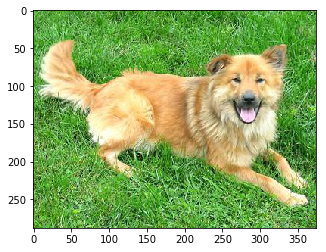

In [21]:
img_path = DIR_IMG_TEST+'4.jpg'
display_img = image.load_img(img_path)
start = time.time()
score = predictFromPath (img_path)
end = time.time()
print("Prediction took {:.3f} seconds".format (end - start))
print("It's a {}! (with a score of {}) 0 -> cat / 1 -> dog".format (getLabelFromScore (score), score))
plt.imshow(display_img)

Yes, it is a dog, not bad... Let's see few predictions at once:

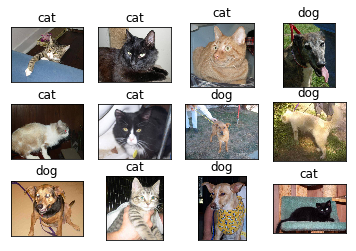

In [22]:
# last test

fig=plt.figure()

plot_test_paths = os.listdir(DIR_IMG_TEST)[50:62]

for num,plot_test_path in enumerate(plot_test_paths):

    y = fig.add_subplot(3,4,num+1)
    orig = image.load_img (DIR_IMG_TEST+plot_test_path)

    prediction = predictFromPath (DIR_IMG_TEST+plot_test_path)
    str_label = getLabelFromScore (prediction)
        
    y.imshow(orig)
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

All of them look correct! Let's do a submission.

## Submission

The submission expects a file with this format:

|id|label|
|--|:----|
|1|0.5|
|2|0.5|
|3|0.5|
|4|0.5|

_id_ is the test id of the picture (contained in the filename). As _label_ the probability it is a dog.

We prepare the data as before creating a numpy object and saving it on disk for later.

In [23]:
# prepare data for submission

submission_imgs = os.listdir(DIR_IMG_TEST)
submission_x = submission_imgs[:]
print ("Number of submission examples = {}".format(len(submission_x)))

submission_imgs = sorted(submission_imgs, key=lambda x: int(x[:x.index('.')]))

Number of submission examples = 12500


12.500 test images in total. Let's do the predictions and export it to a csv.

In [24]:
import csv
from tqdm import tqdm

with open(os.path.join(DIR_OUTPUT,'submission.csv'), 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['id', 'label'])
    for elem in tqdm (submission_imgs):
        prediction = predictFromPath (DIR_IMG_TEST+elem)
        filewriter.writerow([elem[:elem.index('.')], "{:.6f}".format(prediction)])

100%|██████████| 12500/12500 [20:03<00:00, 10.32it/s]


## Result

We got a log loss of **0.216**! This is not bad at all considering the little data we used. We even didn't use data augmentation! That would be the natural next step. There's some overfitting to the training set because we got **0.16** log loss in the evaluation set.

Anyway, we can see the huge difference with respect of the state of the art in 2013.


![screenshot_3](./screenshots/Screen%20Shot%202018-03-18%20at%2016.27.19.png)

The result is calculated with the log loss. The formula for the log loss is the following:

![screenshot_1](./screenshots/Screen%20Shot%202018-03-18%20at%2017.47.23.png)

Its representation: 

![screenshot_2](./screenshots/Screen%20Shot%202018-03-18%20at%2017.47.45.png)

## Conclusion

We could easily beat the state of the art of 2013. The modern deep learning techniques are very powerful. Even with restricted data and training for a few epochs, the result is notably better. We didn't even need a GPU.

As we saw, the model can't generalize well enough and misses around 7% of the pictures it predicts. For that reason and considering the data restriction we imposed to ourselves, **data augmentation** could be an interesting option to achieve a better result. Specially interesting is the built-in Keras functionality called [ImageDataGenerator](https://keras.io/preprocessing/image/). Using this feature and training the model for a few more epochs, we could improve the results above.

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (